In [1]:
import os

import random
import numpy as np
import seaborn as sn
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable

from argparse import Namespace

import time

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tqdm import notebook

import matplotlib.pyplot as plt

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
args = Namespace(
    dataset_dir = ".data",
    dataset_prefix = "faq_with_splits_",
    datasets = ["tokenized", "filtered", "lemmatized", "stemmed", "lemmatized_filtered", "stemmed_filtered"],
    model_save_dir = ".model_storage/MLP",
    model_state_file = "model",
    seed = 1234,
    num_epochs = 5,
    learning_rate = 1e-3,
    hidden_size = 100,
    batch_size = 128,
    cuda = True,
    train_column = ['short_question', 'long_question']
)

In [4]:
device = torch.device('cuda' if args.cuda & torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
args.model_state_file = os.path.join(args.model_save_dir, args.model_state_file)

In [6]:
if not os.path.exists(args.model_save_dir):
    os.makedirs(args.model_save_dir)
    print(f"Created directory {args.model_save_dir}")
else:
    print(f"{args.model_save_dir} directory already exists")

.model_storage/MLP directory already exists


## Loading datasets

In [7]:
faq_dataframes = {}

for dataset in args.datasets:
    df_path = os.path.join(args.dataset_dir, args.dataset_prefix + dataset + ".csv")
    print(f"Opening file: {df_path}")
    faq_dataframes[dataset] = pd.read_csv(df_path)

Opening file: .data\faq_with_splits_tokenized.csv
Opening file: .data\faq_with_splits_filtered.csv
Opening file: .data\faq_with_splits_lemmatized.csv
Opening file: .data\faq_with_splits_stemmed.csv
Opening file: .data\faq_with_splits_lemmatized_filtered.csv
Opening file: .data\faq_with_splits_stemmed_filtered.csv


In [8]:
faq_dataframes[args.datasets[0]].head()

,short_question,long_question,answer,main_category,sub_category,split
0,Vállsérülés gyógytorna,Vállsérülés gyógytorna Az lenne a kérdésem hog...,"edzeni kénealapjába véve mindent váll, hát, tr...",Egészség,"Sérülések, balesetek",train
1,Heti hányszor dehidtratáljam a szervezetemet c...,Heti hányszor dehidtratáljam a szervezetemet c...,"Nem értem miért akarod magad dehidratálni, nem...",Egészség,Bio életmód,train
2,A Doctor Who ban ki a vörös hajú lány,A Doctor Who ban ki a vörös hajú lány,Vagy Amy Pond vagy Donna Noble,Szórakozás,"Filmek, sorozatok",train
3,Vettem 2 törpenyuszit a szobamba 4 5 honapja d...,Vettem 2 törpenyuszit a szobamba 4 5 honapja d...,Egy törpenyuszihoz nagyon sok türelem kell. Pr...,Állatok,Kisemlősök,train
4,Fityma szűkületem van,Fityma szűkületem van 15 éves fiú vagyok és mi...,Valószínű. Esetleg még a fitymaféked lehet röv...,Egészség,Férfiak egészsége,train


## Seperate datasets by splits

In [9]:
def get_dataframes_for_split(split, datasets):
    return {ds: datasets[ds][datasets[ds].split == split] for ds in datasets}

In [10]:
train_dfs = get_dataframes_for_split('train', faq_dataframes)
test_dfs = get_dataframes_for_split('test', faq_dataframes)
valid_dfs = get_dataframes_for_split('val', faq_dataframes)

In [11]:
train_dfs[args.datasets[0]].head()

,short_question,long_question,answer,main_category,sub_category,split
0,Vállsérülés gyógytorna,Vállsérülés gyógytorna Az lenne a kérdésem hog...,"edzeni kénealapjába véve mindent váll, hát, tr...",Egészség,"Sérülések, balesetek",train
1,Heti hányszor dehidtratáljam a szervezetemet c...,Heti hányszor dehidtratáljam a szervezetemet c...,"Nem értem miért akarod magad dehidratálni, nem...",Egészség,Bio életmód,train
2,A Doctor Who ban ki a vörös hajú lány,A Doctor Who ban ki a vörös hajú lány,Vagy Amy Pond vagy Donna Noble,Szórakozás,"Filmek, sorozatok",train
3,Vettem 2 törpenyuszit a szobamba 4 5 honapja d...,Vettem 2 törpenyuszit a szobamba 4 5 honapja d...,Egy törpenyuszihoz nagyon sok türelem kell. Pr...,Állatok,Kisemlősök,train
4,Fityma szűkületem van,Fityma szűkületem van 15 éves fiú vagyok és mi...,Valószínű. Esetleg még a fitymaféked lehet röv...,Egészség,Férfiak egészsége,train


## Drop the unnecessary columns
Keeping the following columns:
- main category
- short question
- long question

In [12]:
def keep_columns(datasets, columns):
    return {ds: datasets[ds][columns] for ds in datasets}

In [13]:
columns = ['main_category', *args.train_column]

train_dfs = keep_columns(train_dfs, columns)
test_dfs = keep_columns(test_dfs, columns)
valid_dfs = keep_columns(valid_dfs, columns)

In [14]:
train_dfs[args.datasets[0]].head()

,main_category,short_question,long_question
0,Egészség,Vállsérülés gyógytorna,Vállsérülés gyógytorna Az lenne a kérdésem hog...
1,Egészség,Heti hányszor dehidtratáljam a szervezetemet c...,Heti hányszor dehidtratáljam a szervezetemet c...
2,Szórakozás,A Doctor Who ban ki a vörös hajú lány,A Doctor Who ban ki a vörös hajú lány
3,Állatok,Vettem 2 törpenyuszit a szobamba 4 5 honapja d...,Vettem 2 törpenyuszit a szobamba 4 5 honapja d...
4,Egészség,Fityma szűkületem van,Fityma szűkületem van 15 éves fiú vagyok és mi...


#### Get the main categories
Get main category names and assign ids for them

In [15]:
target_names = faq_dataframes[args.datasets[0]].main_category.unique().tolist()
target_dict = {k: v for v, k in enumerate(target_names)}

In [16]:
print(target_names)
print(target_dict)

['Egészség', 'Szórakozás', 'Állatok', 'Számítástechnika']
{'Egészség': 0, 'Szórakozás': 1, 'Állatok': 2, 'Számítástechnika': 3}


### Get vocabulary for bag of words

Which way of getting the vocabulary is faster? The primitive approach, iterating over the dataframe row by row, or the sigma male approach, which takes advantage of the library’s potential. This is a rhetorical question. It could be faster imo, but I'm pleased with this speed.

In [17]:
vocab = set()

start_time = int(time.time() * 1000)

for index, row in train_dfs[args.datasets[0]].iterrows():
    for word in row[args.train_column[0]].lower().split():
        vocab.add(word)

end_time = int(time.time() * 1000)

print(f"Getting vocabulary primitively took {(end_time - start_time) / 1000.0} seconds")
print(f"Length of vocabulary is {len(vocab)}")

Getting vocabulary primitively took 3.699 seconds
Length of vocabulary is 115463


In [18]:
vocab = set()

start_time = int(time.time() * 1000)

train_dfs[args.datasets[0]].apply(lambda row: vocab.update(row[args.train_column[0]].lower().split()), axis = 1)

end_time = int(time.time() * 1000)

print(f"Getting vocabulary in style took {(end_time - start_time) / 1000.0} seconds")
print(f"Length of vocabulary is {len(vocab)}")

Getting vocabulary in style took 0.967 seconds
Length of vocabulary is 115463


In [19]:
def get_vocabulary_for_each_dataset(dataframes):
    vocabularies = {}
    
    for dataframe in dataframes:
        vocabularies[dataframe] = {}

        for train_column in args.train_column:
            start_time = int(time.time() * 1000)
        
            vocab = set()
        
            df = dataframes[dataframe]
            df.apply(lambda row: vocab.update(row[train_column].lower().split()), axis = 1)

            vocabularies[dataframe][train_column] = vocab
        
            end_time = int(time.time() * 1000)
        
            print(f"Getting vocabulary for '{dataframe}-{train_column}' dataset " \
                    f"took {(end_time - start_time) / 1000.0} seconds, length = {len(vocab)}")

    return vocabularies

In [20]:
vocabularies = get_vocabulary_for_each_dataset(train_dfs)

Getting vocabulary for 'tokenized-short_question' dataset took 0.942 seconds, length = 115463
Getting vocabulary for 'tokenized-long_question' dataset took 1.874 seconds, length = 342722
Getting vocabulary for 'filtered-short_question' dataset took 0.917 seconds, length = 115443
Getting vocabulary for 'filtered-long_question' dataset took 1.776 seconds, length = 342710
Getting vocabulary for 'lemmatized-short_question' dataset took 0.915 seconds, length = 79600
Getting vocabulary for 'lemmatized-long_question' dataset took 1.791 seconds, length = 263125
Getting vocabulary for 'stemmed-short_question' dataset took 0.918 seconds, length = 140812
Getting vocabulary for 'stemmed-long_question' dataset took 1.831 seconds, length = 562578
Getting vocabulary for 'lemmatized_filtered-short_question' dataset took 0.87 seconds, length = 73516
Getting vocabulary for 'lemmatized_filtered-long_question' dataset took 1.577 seconds, length = 218660
Getting vocabulary for 'stemmed_filtered-short_quest

In [21]:
word = list(vocabularies[args.datasets[0]][args.train_column[0]])[4]
word

'eni'

#### Getting the index for a word

In [22]:
def create_index_of_word(vocabularies):
    index_of_word = {}
    
    for key in vocabularies:
        index_of_word[key] = {}
        
        for col in args.train_column:
            index_of_word[key][col] = {value: key for key, value in enumerate(vocabularies[key][col])}
            
    return index_of_word

In [23]:
index_of_word = create_index_of_word(vocabularies)

In [24]:
idx = index_of_word[args.datasets[0]][args.train_column[0]][word]
idx

4

### Get a batch of sentences

In [25]:
def bow_rep(question, input_size, index_of_word):
    layer = np.zeros(input_size, dtype=float)
    words = question.lower().split()
    
    for word in words:
        word = word.lower()
        if word in index_of_word:
            layer[index_of_word[word]] += 1
    return layer

In [26]:
def get_batch(df, i, batch_size, input_size, index_of_word, train_column):
    batch = df[i * batch_size : (i + 1) * batch_size]
    batch_q = batch[train_column].apply(lambda x: bow_rep(x, input_size, index_of_word))
    targets_df = batch.main_category.apply(lambda x: target_dict[x])
     
    return np.array(batch_q.tolist()), np.array(targets_df.tolist())

## Multilayer Perceptron

In [27]:
class MLP(nn.Module):
     def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.layer_1 = nn.Linear(input_size, hidden_size, bias=True)
        self.relu = nn.ReLU()
        self.layer_2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear(hidden_size, num_classes, bias=True)
 
     def forward(self, x):
        out = self.layer_1(x)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.output_layer(out)
        return out

In [28]:
def class_accuracy(prediction, actual):
    rounded_predictions = prediction.argmax(1)
    correct = (rounded_predictions == actual).float()

    acc = correct.sum() / len(correct)
    return acc

In [29]:
def show_data_to_model(model, df, vocab, index_of_word, optimizer, criterion, bar, train, train_column):
    epoch_loss = 0
    epoch_acc = 0
    
    total_batch = len(df) // args.batch_size
    
    total_predicted = []
    
    for i in range(total_batch):
        batch_X, batch_y = get_batch(df, i, args.batch_size, len(vocab), index_of_word, train_column)
        
        batch_X = Variable(torch.FloatTensor(batch_X))
        batch_y = Variable(torch.LongTensor(batch_y))
        
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        if train:
            optimizer.zero_grad()
            
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        acc = class_accuracy(predictions, batch_y)
        
        if train:
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

        _, predicted = torch.max(predictions.data, 1)
        total_predicted += predicted.tolist()
        
        bar.set_postfix(loss=(epoch_loss / (i + 1)), acc=(epoch_acc / (i + 1)))
        bar.update()
        bar.refresh()

    return epoch_loss / total_batch, epoch_acc / total_batch, total_predicted

In [30]:
def train_model(model, df, vocab, index_of_word, optimizer, criterion, bar, train_column):
    model.train()
    loss, acc, _ = show_data_to_model(model, df, vocab,\
                                      index_of_word, optimizer, criterion, bar, True, train_column)
    
    return loss, acc

In [31]:
def evaluate_model(model, df, vocab, index_of_word, optimizer, criterion, bar, train_column):
    model.eval()

    with torch.no_grad():
        loss, acc, predicted = show_data_to_model(model, df, vocab,\
                                      index_of_word, optimizer, criterion, bar, False, train_column)
        return loss, acc, predicted

In [32]:
train_losses = {}
train_accuracies = {}

valid_losses = {}
valid_accuracies = {}

for dataset_key in args.datasets:
    train_losses[dataset_key] = {}
    train_accuracies[dataset_key] = {}

    valid_losses[dataset_key] = {}
    valid_accuracies[dataset_key] = {}
    
    for train_column in args.train_column:
        train_losses[dataset_key][train_column] = []
        train_accuracies[dataset_key][train_column] = []

        valid_losses[dataset_key][train_column] = []
        valid_accuracies[dataset_key][train_column] = []
    
        best_valid_loss = float('inf')

    
        train_df = train_dfs[dataset_key]
        valid_df = valid_dfs[dataset_key]
        vocabulary = vocabularies[dataset_key][train_column]
        index_of_word_ = index_of_word[dataset_key][train_column]

        model = MLP(len(vocabulary), args.hidden_size, len(target_names))
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()  
        criterion = criterion.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)
    
        train_size = train_df.shape[0] // args.batch_size
        valid_size = valid_df.shape[0] // args.batch_size
    
        epoch_bar = notebook.tqdm(desc=f"'{dataset_key} {train_column}' epoch", total=args.num_epochs, leave=True)
        train_bar = notebook.tqdm(desc=f"'{dataset_key} {train_column}' train", total=train_size, leave=False)
        valid_bar = notebook.tqdm(desc=f"'{dataset_key} {train_column}' valid",total=valid_size, leave=False)
    
        for epoch in range(args.num_epochs):
            train_bar.n = 0
            valid_bar.n = 0

            train_bar.refresh()
            valid_bar.refresh()

            train_loss, train_acc = train_model(model, train_df, vocabulary, index_of_word_, optimizer, criterion, train_bar, train_column)
            valid_loss, valid_acc, _ = evaluate_model(model, valid_df, vocabulary, index_of_word_, optimizer, criterion, valid_bar, train_column)

            train_losses[dataset_key][train_column].append(train_loss)
            train_accuracies[dataset_key][train_column].append(train_acc)

            valid_losses[dataset_key][train_column].append(valid_loss)
            valid_accuracies[dataset_key][train_column].append(valid_acc)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), args.model_state_file + \
                                   "_" + dataset_key + \
                                   "_" + train_column + ".pth")

            epoch_bar.update()
            epoch_bar.refresh()

'tokenized short_question' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'tokenized short_question' train:   0%|          | 0/839 [00:00<?, ?it/s]

'tokenized short_question' valid:   0%|          | 0/179 [00:00<?, ?it/s]

'tokenized long_question' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'tokenized long_question' train:   0%|          | 0/839 [00:00<?, ?it/s]

'tokenized long_question' valid:   0%|          | 0/179 [00:00<?, ?it/s]

'filtered short_question' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'filtered short_question' train:   0%|          | 0/839 [00:00<?, ?it/s]

'filtered short_question' valid:   0%|          | 0/179 [00:00<?, ?it/s]

'filtered long_question' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'filtered long_question' train:   0%|          | 0/839 [00:00<?, ?it/s]

'filtered long_question' valid:   0%|          | 0/179 [00:00<?, ?it/s]

'lemmatized short_question' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'lemmatized short_question' train:   0%|          | 0/839 [00:00<?, ?it/s]

'lemmatized short_question' valid:   0%|          | 0/179 [00:00<?, ?it/s]

'lemmatized long_question' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'lemmatized long_question' train:   0%|          | 0/839 [00:00<?, ?it/s]

'lemmatized long_question' valid:   0%|          | 0/179 [00:00<?, ?it/s]

'stemmed short_question' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'stemmed short_question' train:   0%|          | 0/839 [00:00<?, ?it/s]

'stemmed short_question' valid:   0%|          | 0/179 [00:00<?, ?it/s]

'stemmed long_question' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'stemmed long_question' train:   0%|          | 0/839 [00:00<?, ?it/s]

'stemmed long_question' valid:   0%|          | 0/179 [00:00<?, ?it/s]

'lemmatized_filtered short_question' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'lemmatized_filtered short_question' train:   0%|          | 0/839 [00:00<?, ?it/s]

'lemmatized_filtered short_question' valid:   0%|          | 0/179 [00:00<?, ?it/s]

'lemmatized_filtered long_question' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'lemmatized_filtered long_question' train:   0%|          | 0/839 [00:00<?, ?it/s]

'lemmatized_filtered long_question' valid:   0%|          | 0/179 [00:00<?, ?it/s]

'stemmed_filtered short_question' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'stemmed_filtered short_question' train:   0%|          | 0/839 [00:00<?, ?it/s]

'stemmed_filtered short_question' valid:   0%|          | 0/179 [00:00<?, ?it/s]

'stemmed_filtered long_question' epoch:   0%|          | 0/5 [00:00<?, ?it/s]

'stemmed_filtered long_question' train:   0%|          | 0/839 [00:00<?, ?it/s]

'stemmed_filtered long_question' valid:   0%|          | 0/179 [00:00<?, ?it/s]

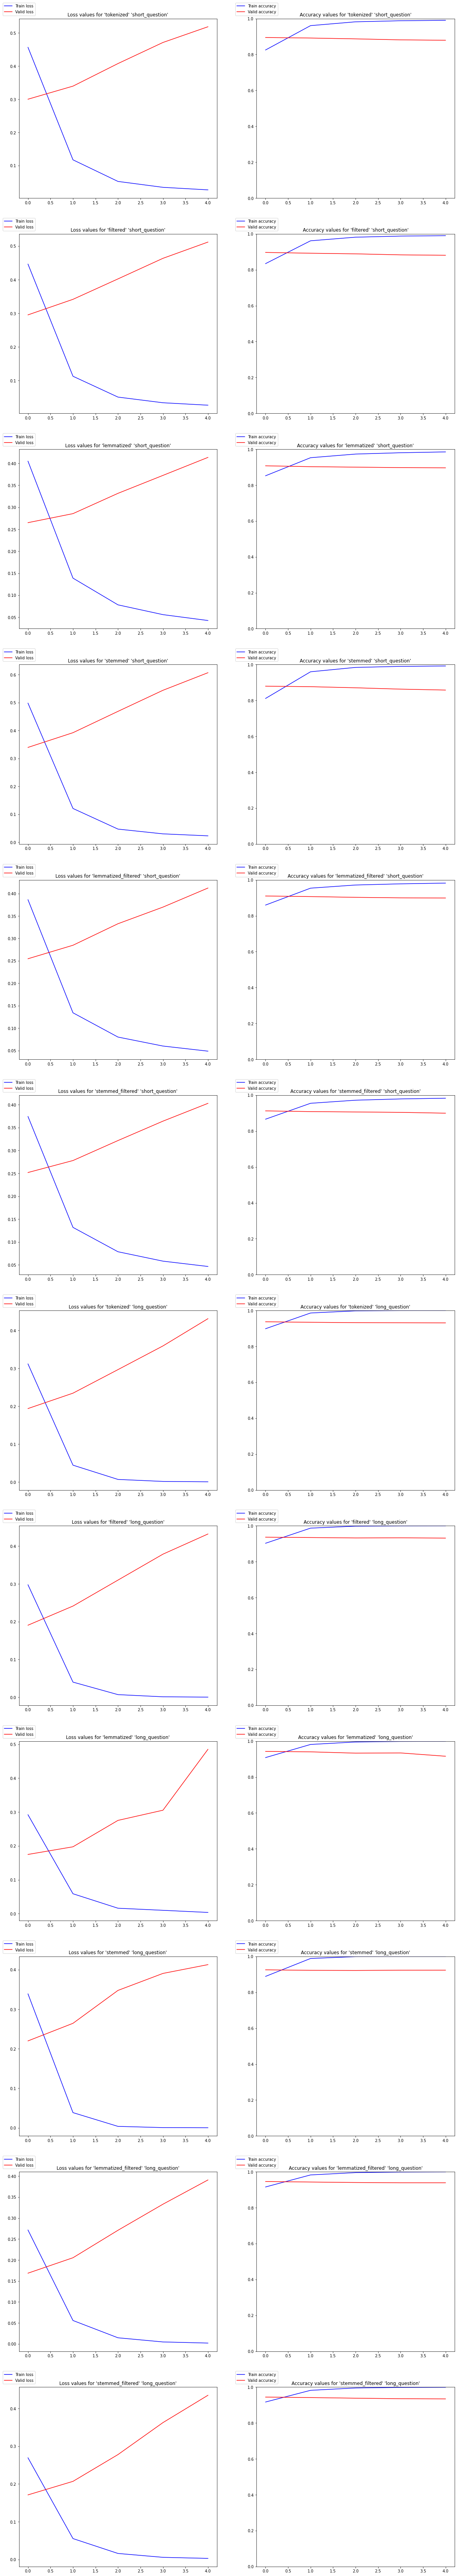

In [33]:
rows = len(args.datasets) * len(args.train_column)

fig, axs = plt.subplots(rows, 2, figsize=(10 * 2, 10 * rows))

for i, col in enumerate(args.train_column):
    for j, ds in enumerate(args.datasets):
        idx = i * len(args.datasets) + j

        axs[idx, 0].set_title(f"Loss values for '{ds}' '{col}'")
        axs[idx, 0].plot([*range(args.num_epochs)], train_losses[ds][col], color = 'b', label='Train loss')
        axs[idx, 0].plot([*range(args.num_epochs)], valid_losses[ds][col], color = 'r', label='Valid loss')
        axs[idx, 0].legend(loc="upper center", bbox_to_anchor=(0.0, 1.1), ncol=1)

        axs[idx, 1].set_title(f"Accuracy values for '{ds}' '{col}'")
        axs[idx, 1].axis(ymin = 0, ymax = 1)
        axs[idx, 1].plot([*range(args.num_epochs)], train_accuracies[ds][col], color = 'b', label='Train accuracy')
        axs[idx, 1].plot([*range(args.num_epochs)], valid_accuracies[ds][col], color = 'r', label='Valid accuracy')
        axs[idx, 1].legend(loc="upper center", bbox_to_anchor=(0.0, 1.1), ncol=1)
    
plt.show()

In [34]:
predictions = {}
test_target = {}

number_of_batches = 0

for dataset_key in args.datasets:
    test_target[dataset_key] = {}
    predictions[dataset_key] = {}

    test_df = test_dfs[dataset_key]
    test_size = test_df.shape[0] // args.batch_size

    for train_column in args.train_column:
        vocabulary = vocabularies[dataset_key][train_column]
        index_of_word_ = index_of_word[dataset_key][train_column]
    
        test_bar = notebook.tqdm(desc=f"'{dataset_key} {train_column}' test", total=test_size, leave=True)

        model = MLP(len(vocabulary), args.hidden_size, len(target_names))
        model.load_state_dict(torch.load(args.model_state_file + "_" + \
                                         dataset_key + "_" + \
                                         train_column + ".pth"))
        model = model.to(device)
        _, _, predictions[dataset_key][train_column] = evaluate_model(model, test_df, vocabulary, \
                                                                index_of_word_, optimizer, criterion, test_bar, train_column)

'tokenized short_question' test:   0%|          | 0/179 [00:00<?, ?it/s]

'tokenized long_question' test:   0%|          | 0/179 [00:00<?, ?it/s]

'filtered short_question' test:   0%|          | 0/179 [00:00<?, ?it/s]

'filtered long_question' test:   0%|          | 0/179 [00:00<?, ?it/s]

'lemmatized short_question' test:   0%|          | 0/179 [00:00<?, ?it/s]

'lemmatized long_question' test:   0%|          | 0/179 [00:00<?, ?it/s]

'stemmed short_question' test:   0%|          | 0/179 [00:00<?, ?it/s]

'stemmed long_question' test:   0%|          | 0/179 [00:00<?, ?it/s]

'lemmatized_filtered short_question' test:   0%|          | 0/179 [00:00<?, ?it/s]

'lemmatized_filtered long_question' test:   0%|          | 0/179 [00:00<?, ?it/s]

'stemmed_filtered short_question' test:   0%|          | 0/179 [00:00<?, ?it/s]

'stemmed_filtered long_question' test:   0%|          | 0/179 [00:00<?, ?it/s]

In [35]:
test_target = test_dfs[args.datasets[0]].main_category.apply(lambda x: target_dict[x]).tolist()

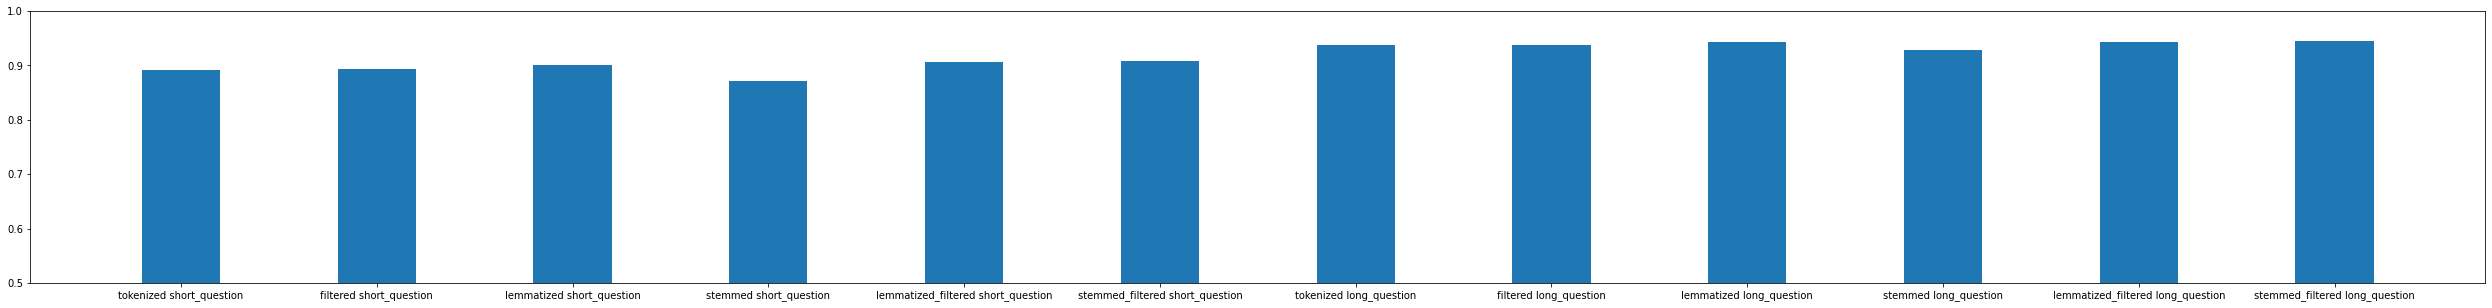

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(44, 5))

accuracy_scores = []
plot_labels = []

for train_column in args.train_column:
    for dataset in args.datasets:
        plot_labels.append(dataset + " " + train_column)

        pred = predictions[dataset][train_column]
        
        accuracy_scores.append(accuracy_score(test_target[:len(pred)], pred))

ax.axis(ymin = 0.50, ymax = 1)
ax.bar(plot_labels, accuracy_scores, width=0.4)

plt.show()

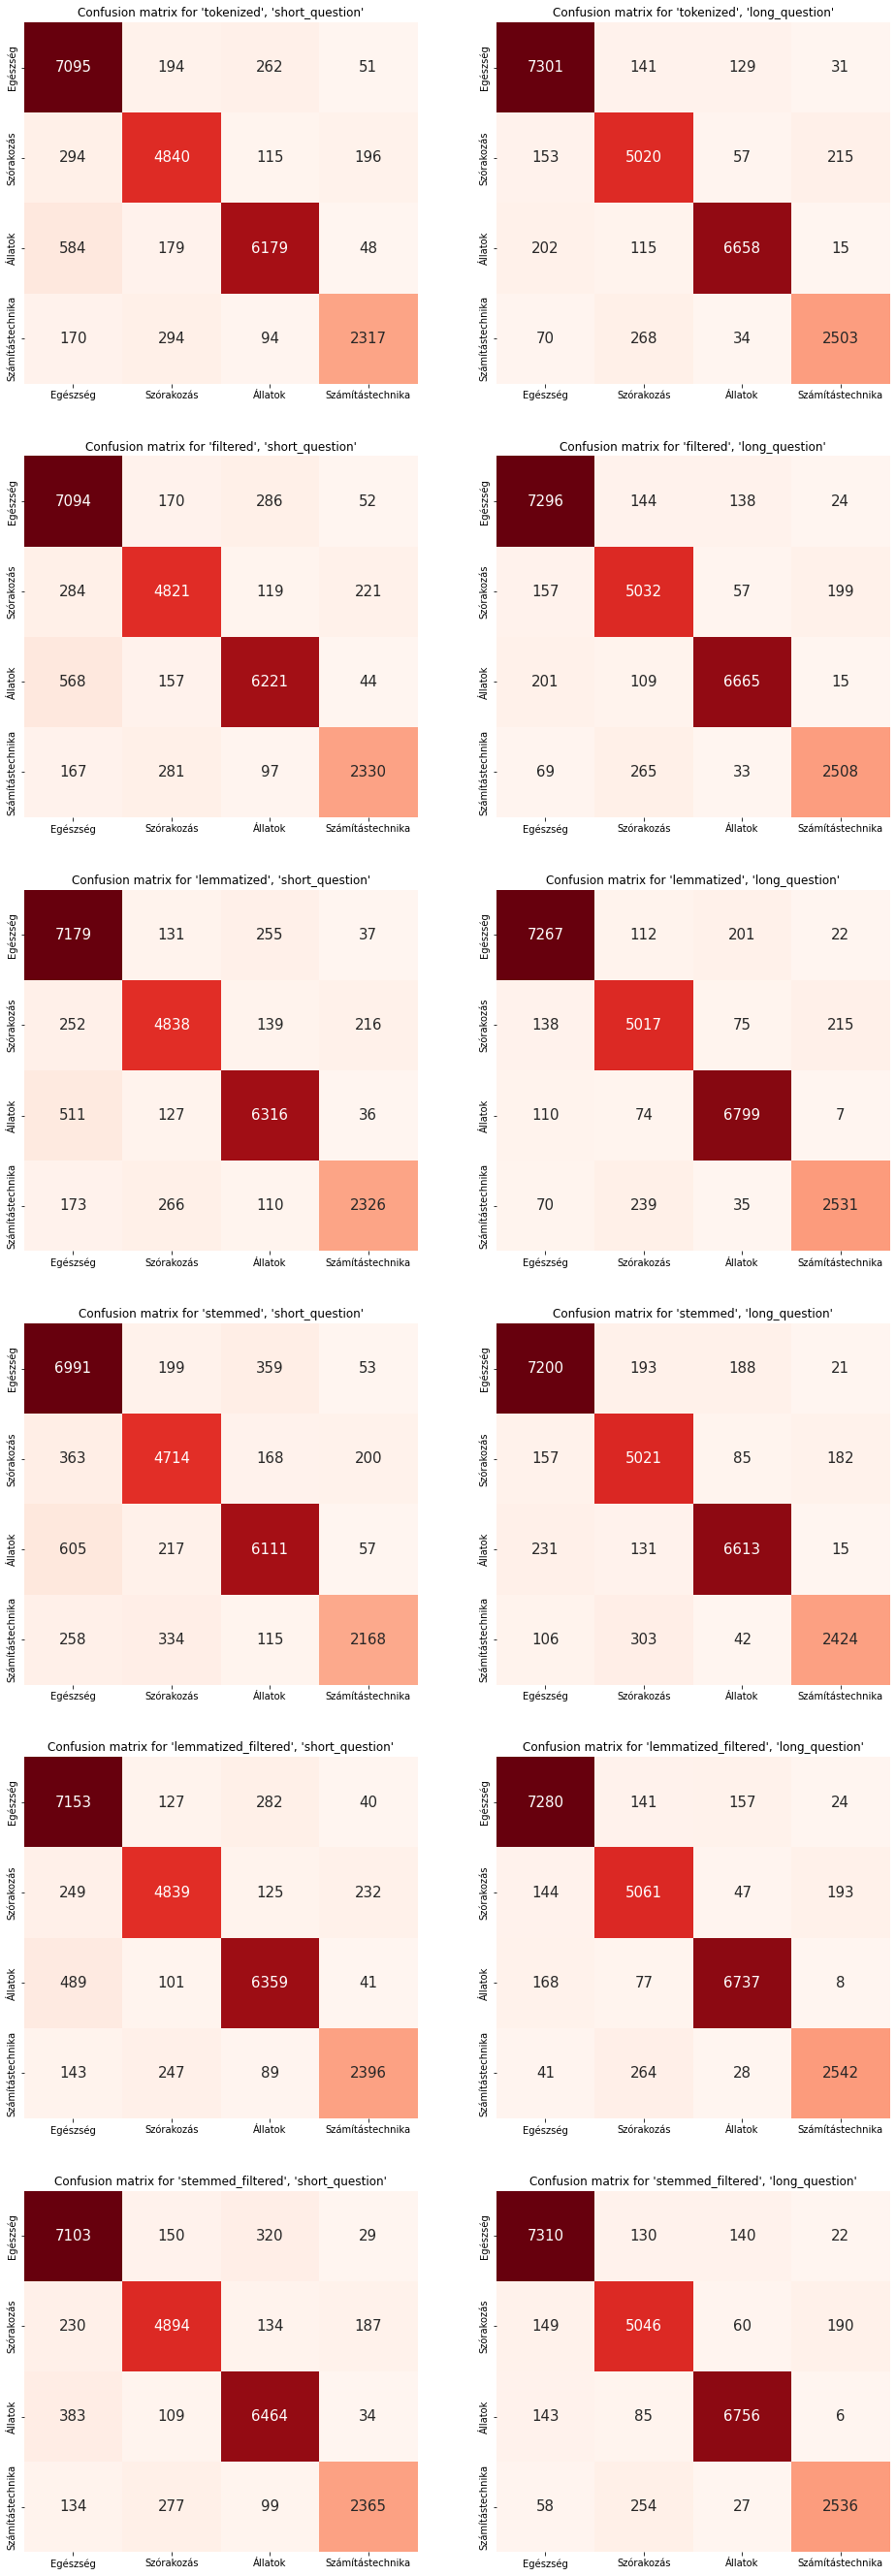

In [37]:
fig, axs = plt.subplots(len(args.datasets), len(args.train_column), figsize=(8 * len(args.train_column), 8 * len(args.datasets)))

for i, dataset in enumerate(args.datasets):
    for j, train_column in enumerate(args.train_column):
        axs[i, j].set_title(f"Confusion matrix for '{dataset}', '{train_column}'")
    
        pred = predictions[dataset][train_column]
    
        cm = confusion_matrix(test_target[:len(pred)], pred)
        cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
    
        heatmap = sn.heatmap(cm_df, annot=True, ax=axs[i, j], cmap='Reds', fmt='g', annot_kws={"size": 15}, cbar=False)

plt.show()

In [38]:
for dataset_key in args.datasets:
    for train_column in args.train_column:
        pred = predictions[dataset_key][train_column]
        report = classification_report(test_target[:len(pred)], pred, target_names=target_names)
        print(f"Classification report for '{dataset_key}' '{train_column}':\n{report}\n{'=' * 60}")

Classification report for 'tokenized' 'short_question':
                  precision    recall  f1-score   support

        Egészség       0.87      0.93      0.90      7602
      Szórakozás       0.88      0.89      0.88      5445
         Állatok       0.93      0.88      0.91      6990
Számítástechnika       0.89      0.81      0.84      2875

        accuracy                           0.89     22912
       macro avg       0.89      0.88      0.88     22912
    weighted avg       0.89      0.89      0.89     22912

Classification report for 'tokenized' 'long_question':
                  precision    recall  f1-score   support

        Egészség       0.94      0.96      0.95      7602
      Szórakozás       0.91      0.92      0.91      5445
         Állatok       0.97      0.95      0.96      6990
Számítástechnika       0.91      0.87      0.89      2875

        accuracy                           0.94     22912
       macro avg       0.93      0.93      0.93     22912
    weighted a